In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect
from datetime import datetime
from sqlalchemy import func ,bindparam,distinct
import dateutil.relativedelta

import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Create the connection engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
Base = automap_base()

In [4]:
Base.prepare(engine, reflect=True)

In [5]:
Base.classes.keys()

['measurements', 'stations']

In [6]:
Station = Base.classes.stations
Measurement = Base.classes.measurements

In [7]:
start_trip_date = input('Enter trip start date in YYYY-MM-DD format')
try:
    year, month, day = map(int, start_trip_date.split('-'))
except ValueError:
    print("Incorrect format,please re enter Start Date")


Enter trip start date in YYYY-MM-DD format2018-01-01


In [8]:
start_date = datetime(year,month,day)

In [9]:
end_trip_date = input('Enter trip end date in YYYY-MM-DD format')
try:
    year, month, day = map(int, end_trip_date.split('-'))
except ValueError:
    print("Incorrect format,please re enter end Date")

Enter trip end date in YYYY-MM-DD format2018-01-11


In [10]:
end_date = datetime(year,month,day)

In [11]:
d = end_date - start_date

In [12]:
if (d.days < 3 or d.days > 15):
    print("Please re-enter dates ,trip should be between 3 and 15 days ")
else:
    session = Session(engine)

In [13]:
    max_date = session.query(func.max(Measurement.date))\
             .all()[0][0]
    d1 = datetime.strptime(max_date,"%Y-%m-%d")
    d2 = d1 - dateutil.relativedelta.relativedelta(months=12)
    min_date = d2.strftime("%Y-%m-%d")
    print(max_date)
    print(min_date)

2017-08-23
2016-08-23


In [14]:
    stmt = session.query(Measurement.date,func.avg(Measurement.prcp).label("precipitation"))\
            .filter(Measurement.date >= min_date)\
            .filter(Measurement.date <= max_date)\
            .group_by(Measurement.date).order_by(Measurement.date.asc()).statement

In [15]:
    df_precp = pd.read_sql_query(stmt, session.bind)
    

In [16]:
    df_precp = df_precp.set_index('date')


In [17]:
    ax = df_precp[["precipitation"]].plot(kind='area', figsize=(10, 10))


<IPython.core.display.Javascript object>


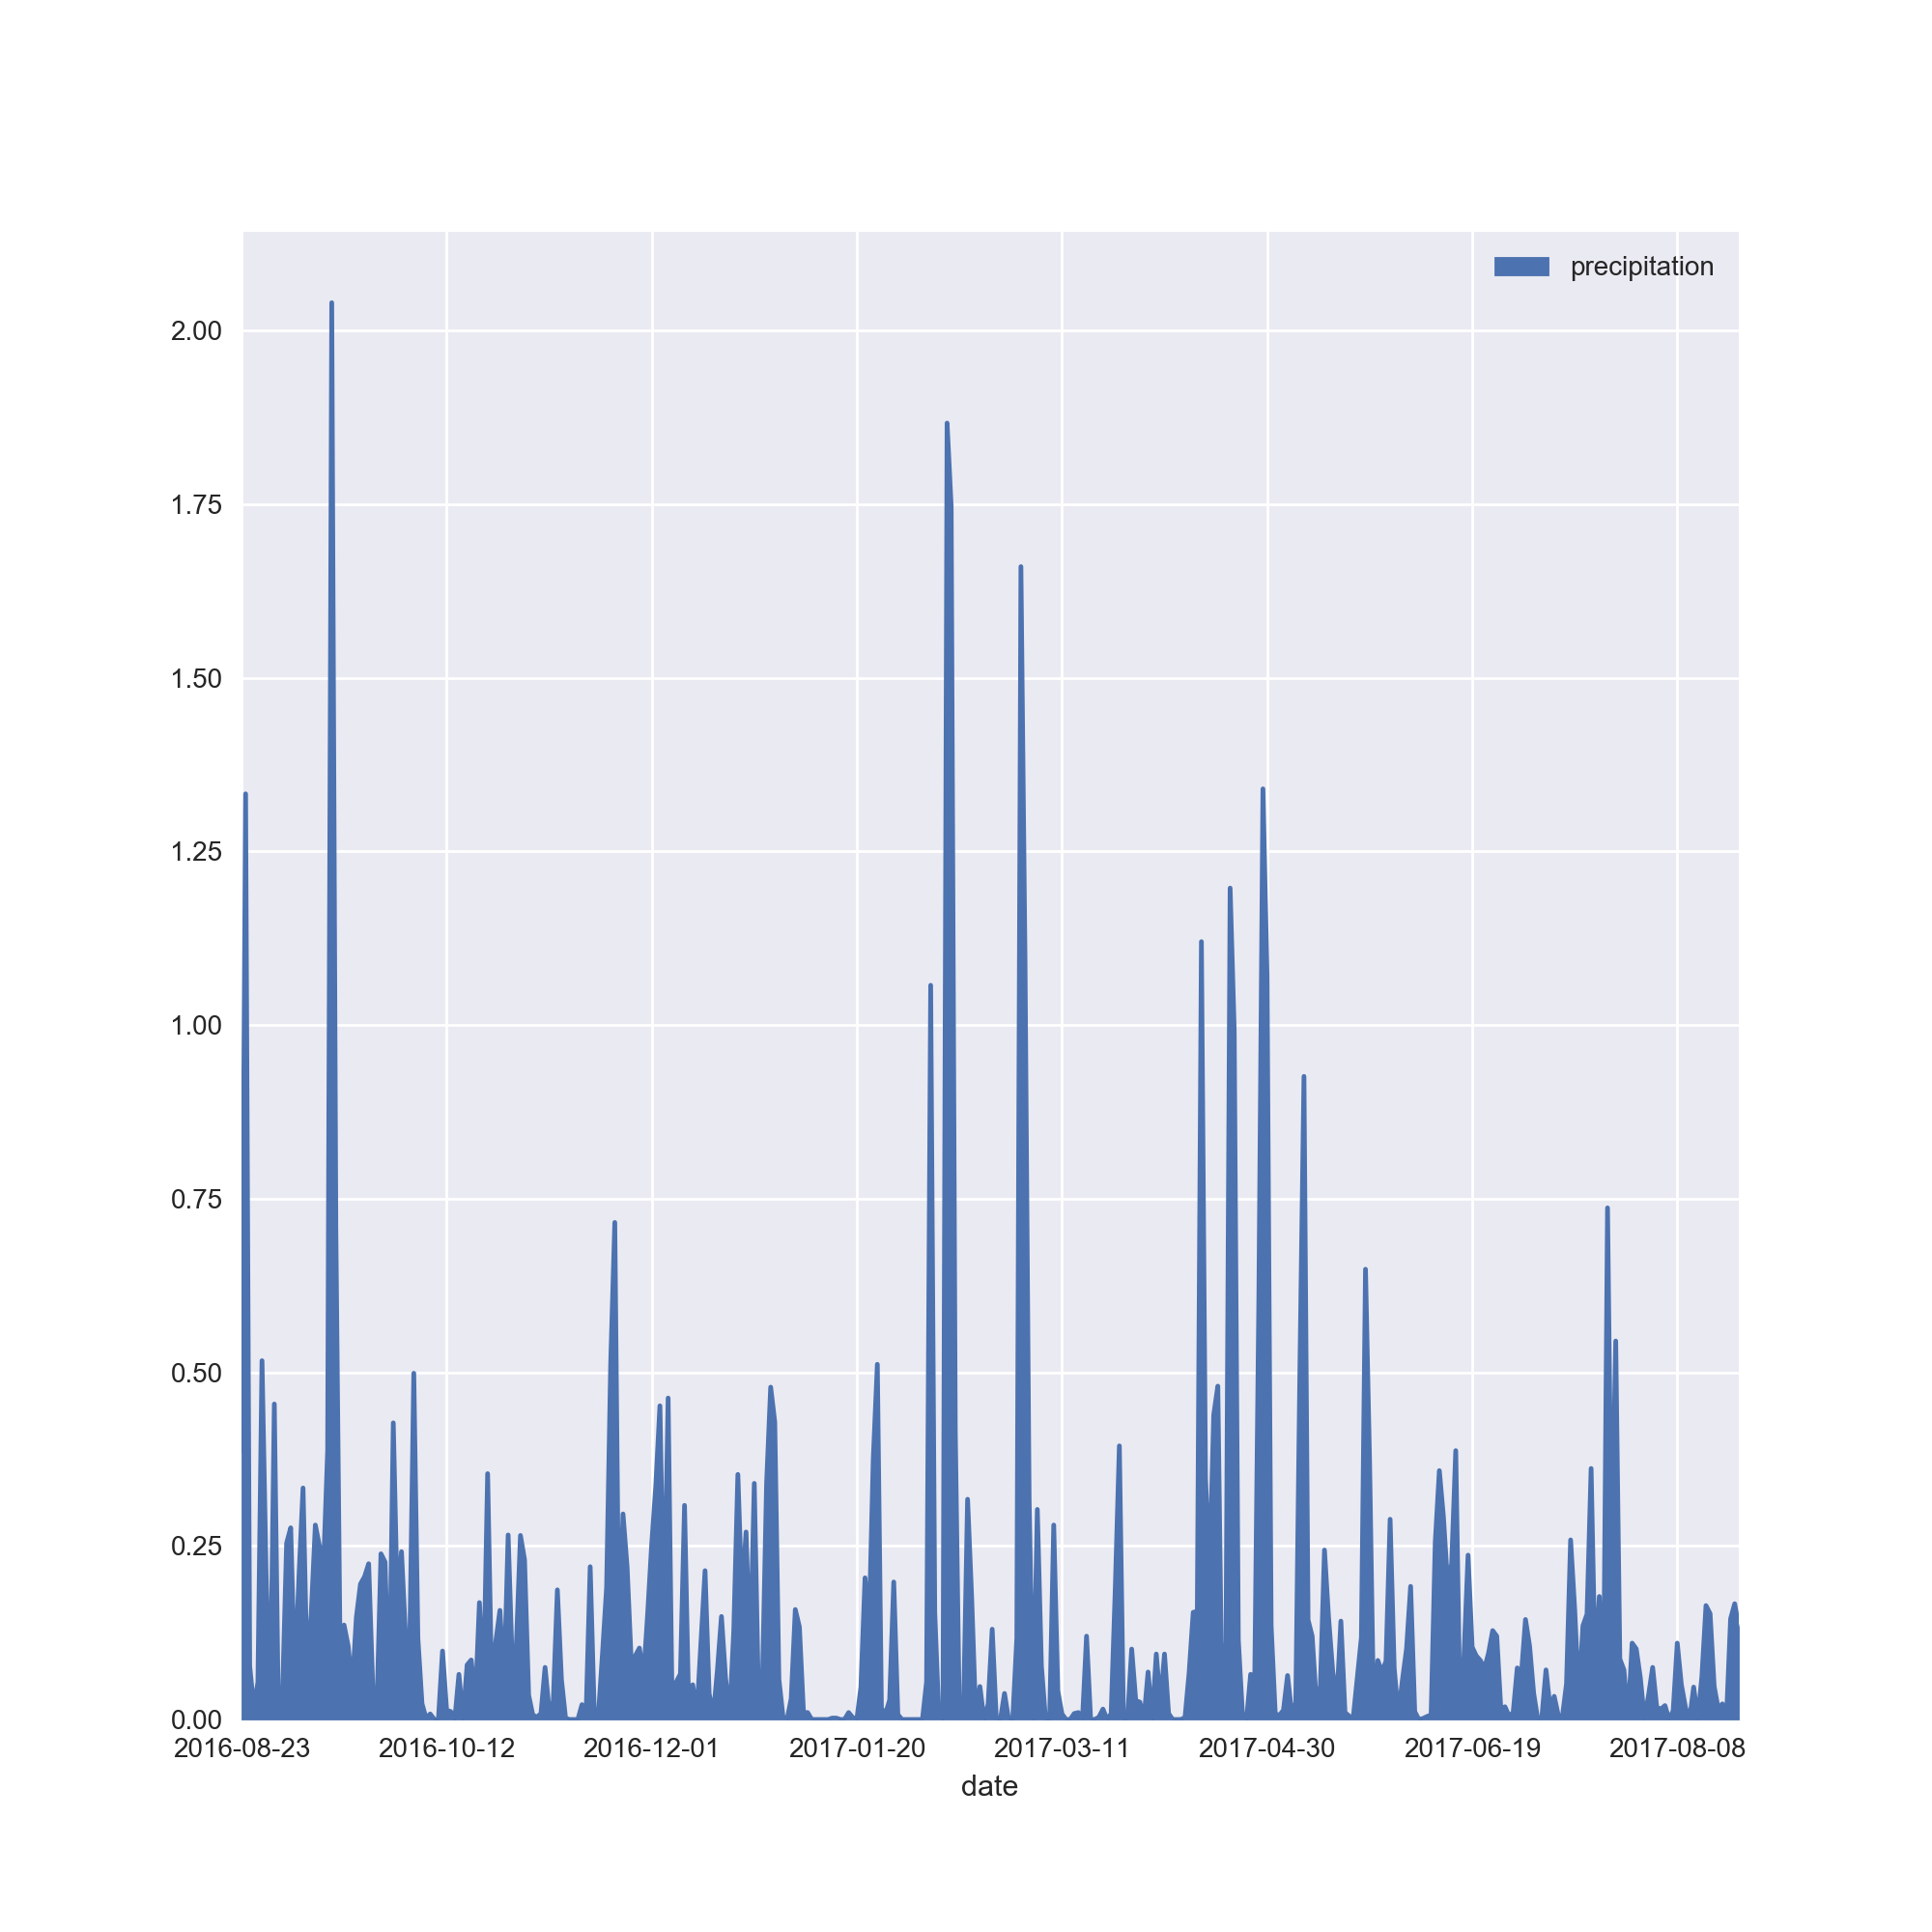

In [18]:
    plt.show()


In [19]:
    df_precp.describe()

,precipitation
count,366.000000
mean,0.156734
std,0.275544
min,0.000000
25%,0.008571
50%,0.065357
75%,0.176786
max,2.040000


#    # Station Analysis

In [20]:
    total_stations = session.query(distinct(Station.id)).count()

In [21]:
    print(f"There are a Total of {total_stations} Stations") 

There are a Total of 9 Stations


In [22]:
    result = session.query(Measurement.station_id,func.count(Measurement.tobs).label("Total_tobs"))\
             .filter(Measurement.tobs > 0 )\
             .group_by(Measurement.station_id).order_by(func.count(Measurement.tobs).desc()).all()

In [23]:
    print("*" * 100)
    print("Station" + "     -    " + " Observation Count")
    print("*" * 100)
    for rec in result:
        
        print(f"{rec[0]} -     {rec[1]}")

****************************************************************************************************
Station     -     Observation Count
****************************************************************************************************
USC00519281 -     2772
USC00519397 -     2724
USC00513117 -     2709
USC00519523 -     2669
USC00516128 -     2612
USC00514830 -     2202
USC00511918 -     1979
USC00517948 -     1372
USC00518838 -     511


In [24]:
    print(f"Station {result[0][0]} has a max of {result[0][1]} Observations") 
    

Station USC00519281 has a max of 2772 Observations


In [25]:
    stmt = session.query(Measurement.tobs.label("tobs")).filter(Measurement.date >= min_date)\
                  .filter(Measurement.date <= max_date).filter(Measurement.tobs > 0 )\
                  .filter(Measurement.station_id == result[0][0] ).statement

In [26]:
    df_tobs = pd.read_sql_query(stmt, session.bind)
    df_tobs.head()

,tobs
0,77
1,77
2,80
3,80
4,75


<IPython.core.display.Javascript object>


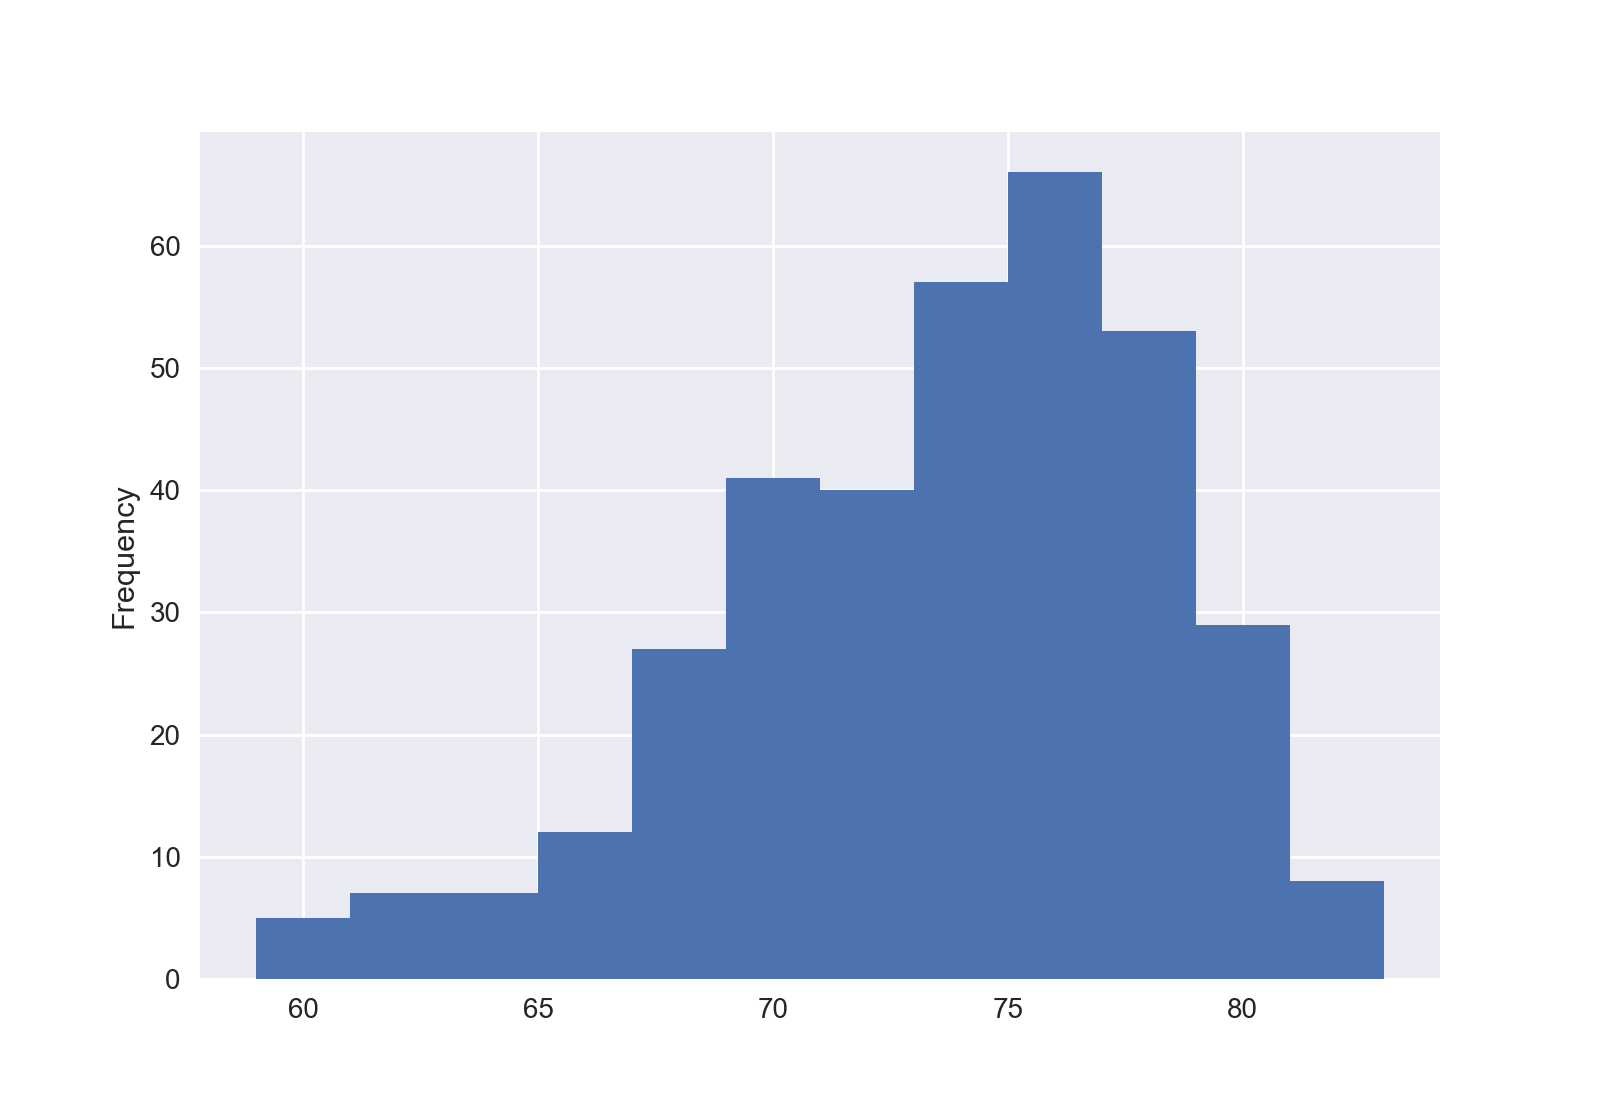

In [27]:
    df_tobs["tobs"].hist(bins=12)
    plt.ylabel("Frequency")
    plt.savefig("Histogram Tobs.png")
    plt.show()

# Temperature Analysis

In [28]:
    # Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
    # and return the minimum, average, and maximum temperatures for that range of dates
    def calc_temps(start_date, end_date):
        """TMIN, TAVG, and TMAX for a list of dates.
    
        Args:
            start_date (string): A date string in the format %Y-%m-%d
            end_date (string): A date string in the format %Y-%m-%d
        
        Returns:
            TMIN, TAVE, and TMAX
        """
    
        return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
            filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


In [29]:
    
    start_date_12 = start_date - dateutil.relativedelta.relativedelta(months=12)
    yr_from_start = d2.strftime("%Y-%m-%d")
    print(yr_from_start)
    
    t_min,t_avg,t_max = calc_temps(yr_from_start, start_trip_date)[0]

2016-08-23


In [30]:
    plt.bar(0, t_avg, color='r', alpha=0.5, align="edge",yerr=(t_max - t_min))
    plt.xlim(-0.25, 1) 
    plt.ylim(0, t_avg + ((t_max - t_min)) + 20)
    plt.xticks([0.4],[' '])
    plt.title("Trip Avg Temp")
    plt.ylabel("Temp (F)")
    plt.tight_layout()
#     plt.figsize=(10, 20)

<IPython.core.display.Javascript object>


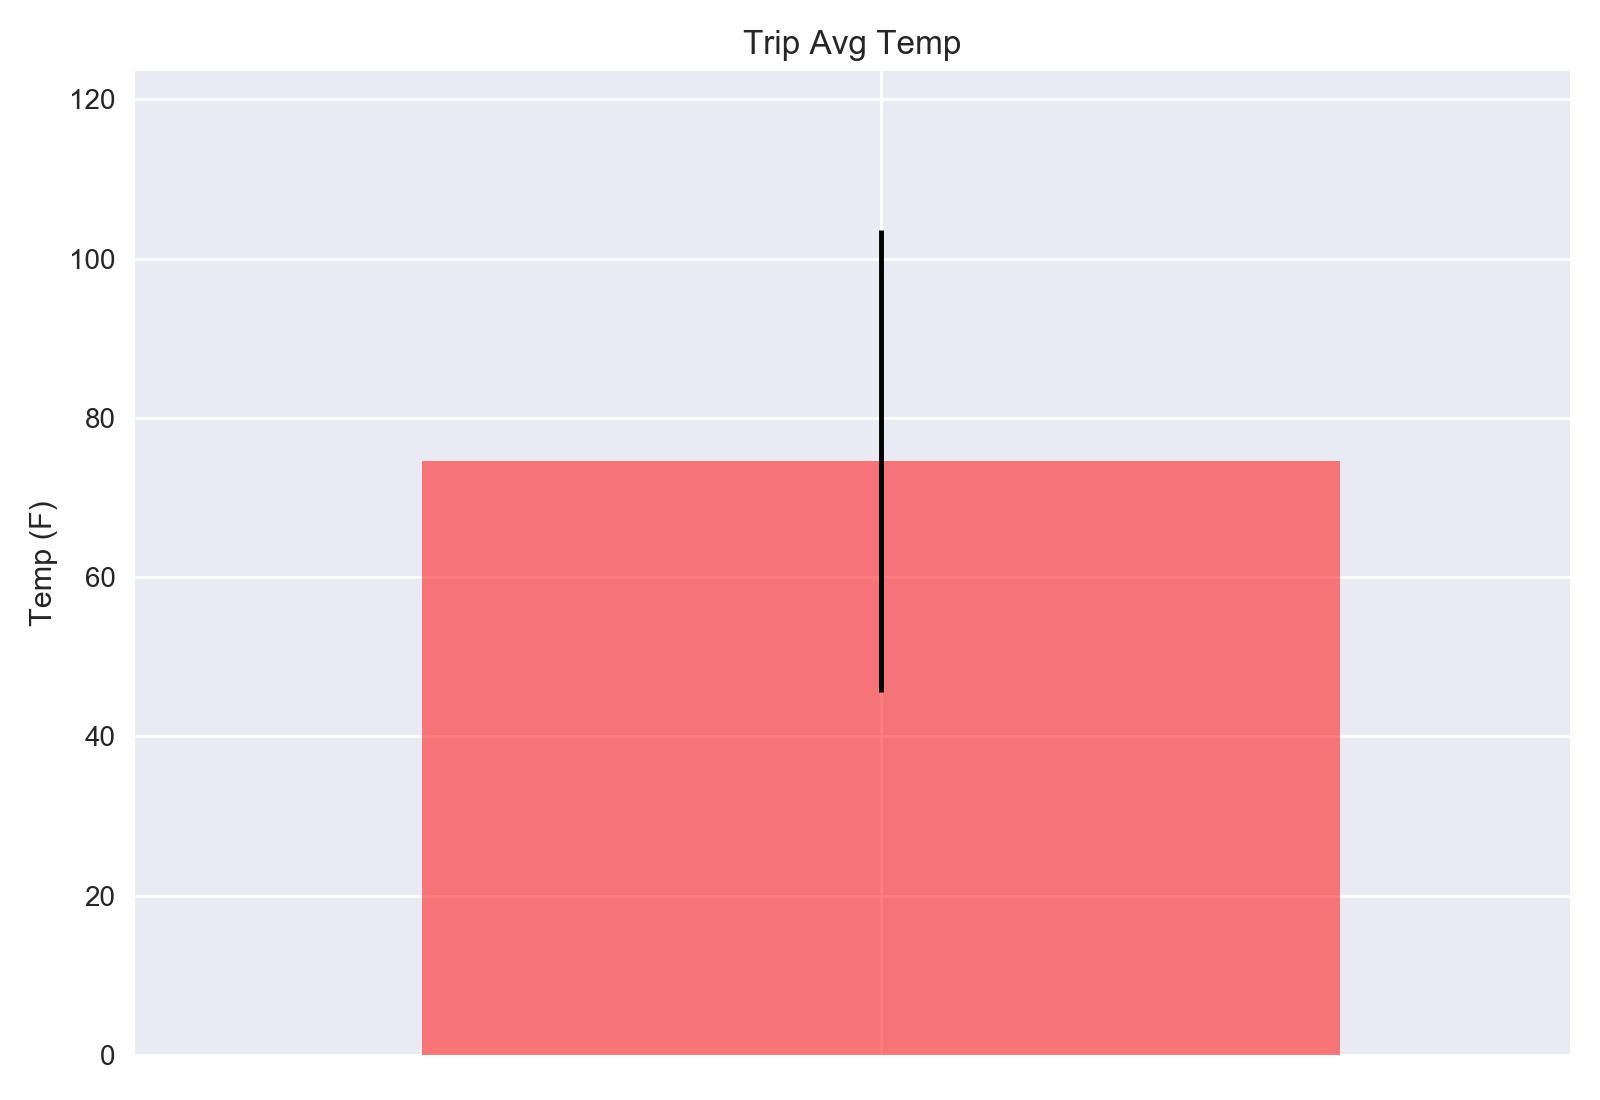

In [31]:
    plt.show()

# Optional Recommended Analysis

# Calcualte the rainfall per weather station using the previous year's matching dates.

In [32]:
    d1 = datetime.strptime(end_trip_date,"%Y-%m-%d")
    d2 = d1 - dateutil.relativedelta.relativedelta(months=12)
    prev_max_date = d2.strftime("%Y-%m-%d")
    print(prev_max_date)
    d1 = datetime.strptime(start_trip_date,"%Y-%m-%d")
    d2 = d1 - dateutil.relativedelta.relativedelta(months=12)
    prev_min_date = d2.strftime("%Y-%m-%d")
    print(prev_min_date)
    
    session.query(Measurement.station_id, func.round(func.avg(Measurement.prcp),2)).\
            filter(Measurement.date >= prev_min_date).filter(Measurement.date <= prev_max_date)\
            .group_by(Measurement.station_id).all()


2017-01-11
2017-01-01


[('USC00513117', 0.03),
 ('USC00514830', 0.06),
 ('USC00516128', 0.06),
 ('USC00517948', 0.0),
 ('USC00519281', 0.02),
 ('USC00519397', 0.0),
 ('USC00519523', 0.07)]

# Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.

In [33]:
    # Write a function called `daily_normals` that will accept partial date with '%m-%d' 
    # and return the minimum, average, and maximum temperatures for the month and date for all the years
    def daily_normals(match_date):
        """TMIN, TAVG, and TMAX for a list of dates.
    
        Args:
            match_date : date with month and date only
        
        Returns:
            TMIN, TAVE, and TMAX
        """
        match_date = "%" + match_date
        return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs)\
                             , func.max(Measurement.tobs)).\
                filter(Measurement.date.like(match_date) ).all()

In [34]:
lst = np.arange(np.datetime64(start_trip_date), np.datetime64(end_trip_date))

In [35]:
lst = np.append(lst, np.datetime64(end_trip_date))

In [36]:
df_daily_normals = pd.DataFrame(index=lst ,columns=["tmin","tavg","tmax","date"])

In [37]:
# df_daily_normals = df_daily_normals.fillna(value=0)

In [38]:
for index,row in df_daily_normals.iterrows():
    result = daily_normals(index.strftime("%m-%d"))
    row["tmin"]= result[0][0]
    row["tavg"]= result[0][1]
    row["tmax"]= result[0][2]
    row["date"] = index.strftime("%Y-%m-%d")

In [39]:
df_daily_normals = df_daily_normals.reset_index()

In [40]:
df_daily_normals = df_daily_normals.set_index("date")

<IPython.core.display.Javascript object>


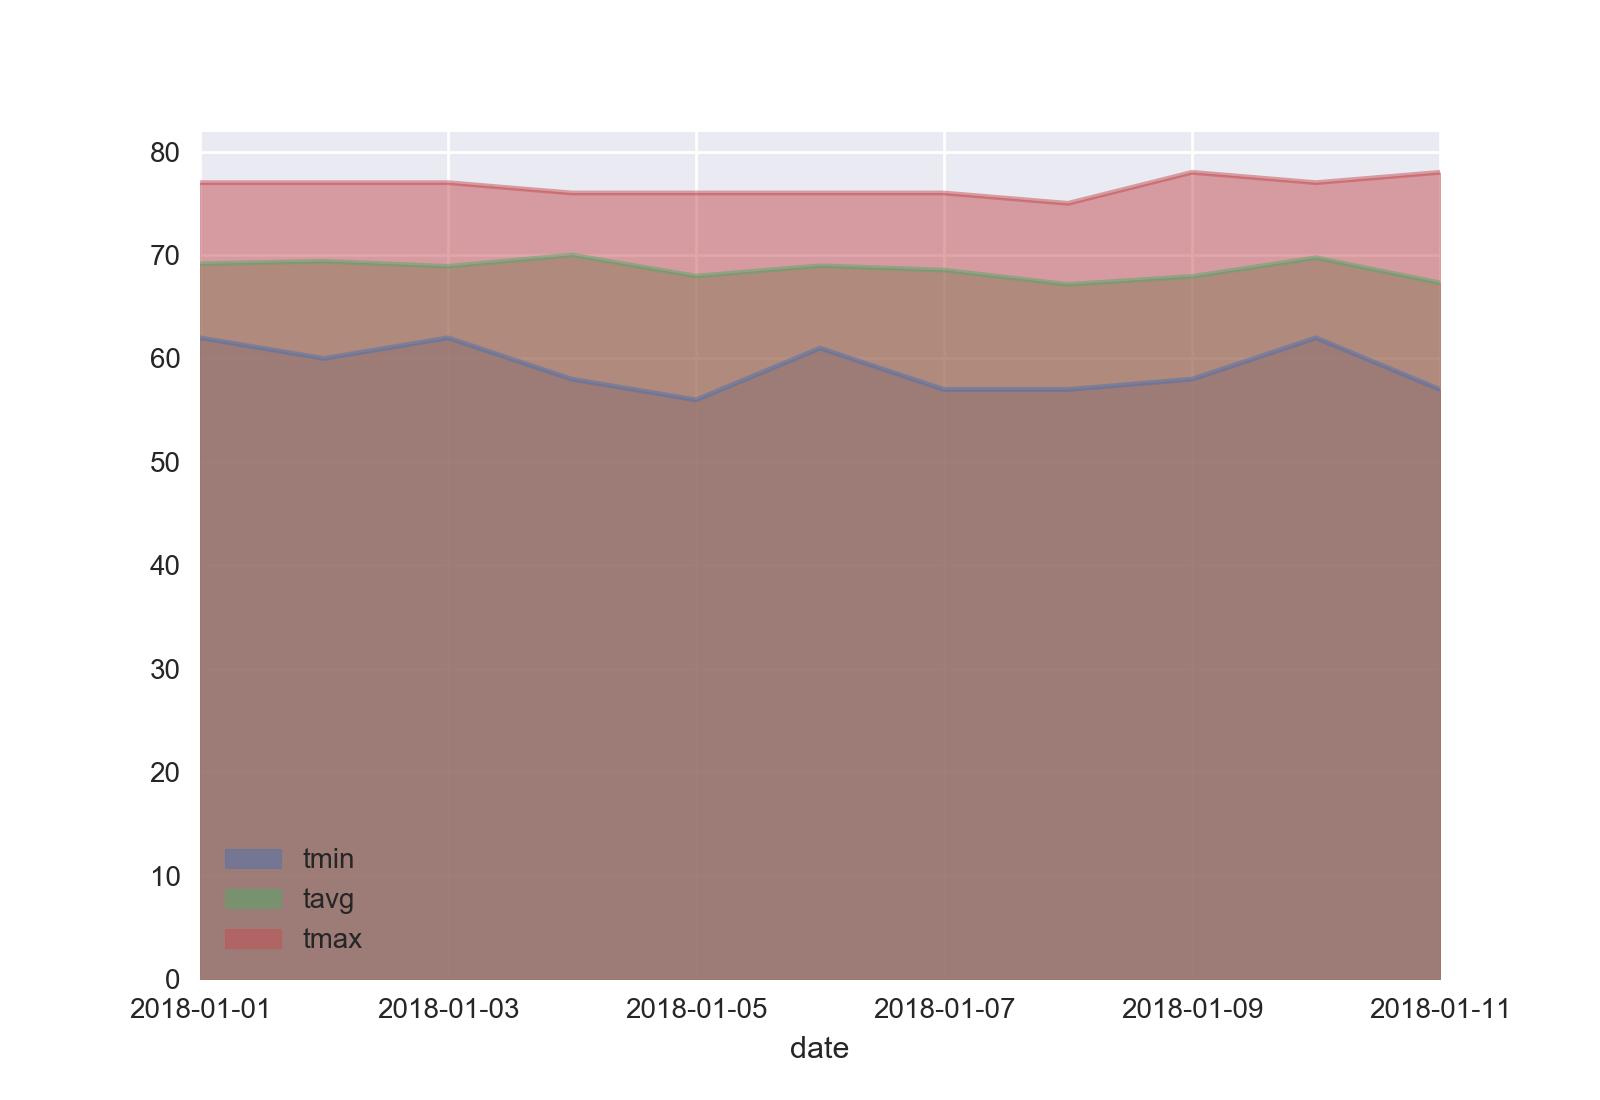

In [41]:
df_daily_normals[["tmin","tavg",'tmax']].plot(kind='area',stacked=False)
plt.show()